In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

In [3]:
data_path = "./data/jigsaw-toxic-severity-rating/"
validation_data = pd.read_csv(data_path+"validation_data.csv")
data = pd.read_csv(data_path+"comments_to_score.csv")

In [4]:
validation_data.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


In [5]:
worker_freq_dict = dict(validation_data.worker.value_counts())
workers = sorted(list(worker_freq_dict.keys()))
worked = [worker_freq_dict[w] for w in workers]

### Plotting worker productivity

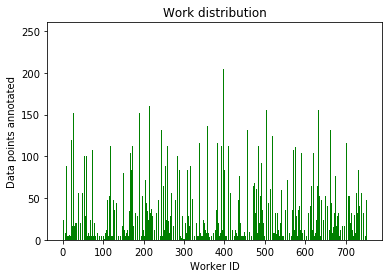

In [15]:
plt.bar(workers, worked, align='center', color='green')
# plt.xticks(workers, worked)
plt.title("Work distribution")
plt.xlabel("Worker ID")
plt.ylabel("Data points annotated")
plt.show()

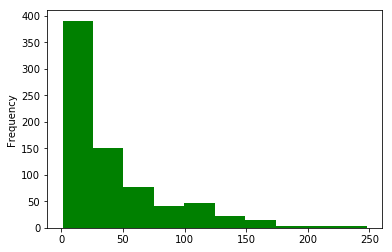

In [22]:
fig, ax = plt.subplots()
validation_data.worker.value_counts().plot(ax=ax, kind='hist', color='green')
plt.show()

### Plotting length of each comment against type of comment

In [7]:
less_toxic_lens = validation_data.less_toxic.apply(lambda x: len(x.split()))
more_toxic_lens = validation_data.more_toxic.apply(lambda x: len(x.split()))

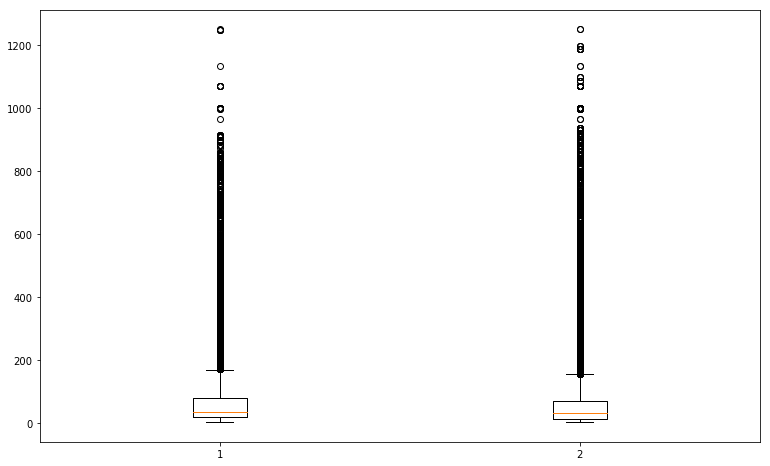

In [12]:
fig = plt.figure(figsize =(10, 6))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot([less_toxic_lens, more_toxic_lens])
 
# show plot
plt.show()


## Tf-idf + SVM classifier approach

Here we train a simple tf-idf featured SVM model, and rank sentences according to the final score